In [1]:
import numpy as np, pandas as pd
from glob import glob
from matplotlib import pyplot as plt

%matplotlib inline

Sample was generated using queries similar to the following, in 60$^{\circ}$ slices in Galactic longitude.
```
SELECT gaia.source_id, wise_match.original_ext_source_id, wise_match.allwise_oid, wise.designation, gaia.ra, gaia.dec, gaia.parallax, gaia.parallax_error, gaia.a_g_val, gaia.phot_g_mean_mag, gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag, wise.w1mpro, wise.w1mpro_error, wise.w2mpro, wise.w2mpro_error
FROM gaiadr2.gaia_source as gaia 
INNER JOIN gaiadr2.allwise_best_neighbour as wise_match ON gaia.source_id = wise_match.source_id
INNER JOIN gaiadr1.allwise_original_valid as wise ON wise_match.allwise_oid=wise.allwise_oid
WHERE gaia.parallax > 0
AND gaia.phot_g_mean_mag + 5 * log10(gaia.parallax) - 10 - gaia.a_g_val <= 0
AND gaia.l >= 0
AND gaia.l < 60
AND wise.w1mpro < 14
```

In [2]:
tables = glob('bright_*result.csv')

In [3]:
#check that we're only getting the files we want
tables

['bright_0-60-result.csv',
 'bright_120-180-result.csv',
 'bright_180-240-result.csv',
 'bright_240-300-result.csv',
 'bright_300-360-result.csv',
 'bright_60-120-result.csv']

In [4]:
#Put together the individual results
dfs = []
for t in tables:
    temp = pd.read_csv(t)
    dfs.append(temp)
    
result = pd.concat(dfs)

In [5]:
#Synthesize Gaia M_G mag, and tell us how long the result is
M_G = result['phot_g_mean_mag'] + 5 * np.log10(result['parallax']) - 10 - result['a_g_val']
result['M_G'] = M_G
len(result)

7609483

In [6]:
#Which columns have NaNs in them?
for col,dt in zip(result.columns,result.dtypes):
    if (dt != object):
        if np.any(np.isnan(result[col])):
            print(col)

w1mpro_error
w2mpro
w2mpro_error


In [7]:
#Take only rows without NaNs, with SNR in W1 and W2 > 100, but fainter than the saturation limit
#From http://wise2.ipac.caltech.edu/docs/release/neowise/expsup/sec2_1c.html
good_cond = (
    (~np.isnan(result['w1mpro_error'])) & 
    (~np.isnan(result['w2mpro_error'])) & 
    (~np.isnan(result['w2mpro'])) &
    (result['w1mpro_error']/result['w1mpro'] <= 0.01) &
    (result['w2mpro_error']/result['w2mpro'] <= 0.01) &
    (result['w1mpro'] >= 8.0) &
    (result['w2mpro'] >= 7.0)
)
             
good = result[good_cond]
len(good)

7024804

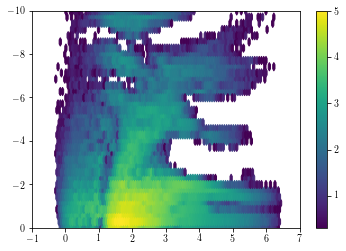

In [8]:
#The full CMD
plt.hexbin(good['phot_bp_mean_mag']-good['phot_rp_mean_mag'],good['M_G'],mincnt=1,bins='log')

plt.xlim(-1,7)
plt.ylim(0,-10)
plt.colorbar()

Text(0,0.5,'N')

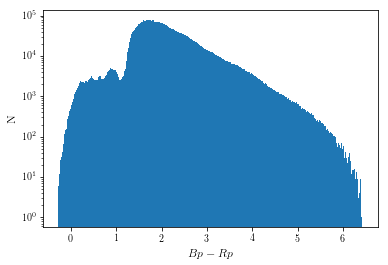

In [9]:
#Distribution of Bp - Rp
plt.hist(good['phot_bp_mean_mag']-good['phot_rp_mean_mag'],bins=500);
plt.yscale('log')
plt.xlabel(r'$Bp-Rp$')
plt.ylabel('N')

Text(0,0.5,'N')

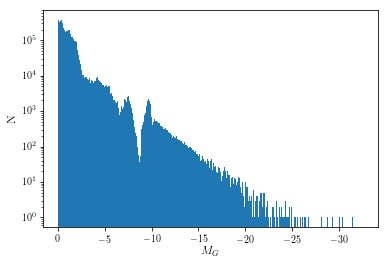

In [10]:
#Distribution of Absolute G mag
plt.hist(good['M_G'],bins=500);
plt.yscale('log')
plt.gca().invert_xaxis()
plt.xlabel(r'$M_G$')
plt.ylabel('N')

Text(0,0.5,'N')

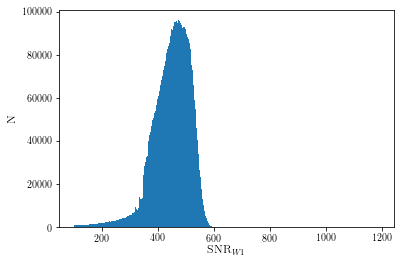

In [11]:
#Distribution of SNR in W1
plt.hist(good['w1mpro']/good['w1mpro_error'],bins=500);
plt.xlabel('SNR$_{W1}$')
plt.ylabel('N')

Text(0,0.5,'N')

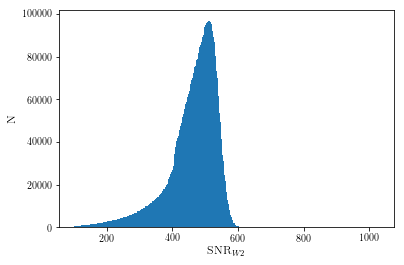

In [12]:
#Distribution of SNR in W2
plt.hist(good['w2mpro']/good['w2mpro_error'],bins=500);
plt.xlabel('SNR$_{W2}$')
plt.ylabel('N')

In [13]:
#Calculating W1-W2, and associated errors.
w1w2 = good['w1mpro'] - good['w2mpro']
w1w2_err = np.sqrt(good['w1mpro_error']*good['w1mpro_error'] + good['w2mpro_error']*good['w2mpro_error'])

Text(0,0.5,'N')

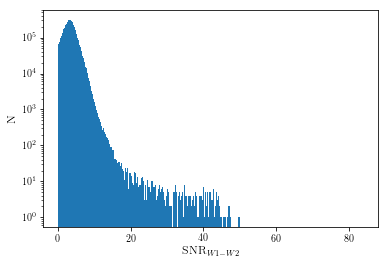

In [14]:
#Histogram of SNR in W1-W2
plt.hist(np.abs(w1w2)/w1w2_err,bins=500);
plt.yscale('log')
plt.xlabel('SNR$_{W1-W2}$')
plt.ylabel('N')

In [17]:
#Let's only take the 2000 brightest (in W1) stars in each ~1 mag color bin. 
#Edges should be everything bluer than 0, redder than 6, then 1 mag chunks
dfs = []
for i in range(8): #i is the color of the right edge of the bin, except the last which is open
    if i == 0: #everything bluer than BP-RP = 0
        subset = good[good['phot_bp_mean_mag']-good['phot_rp_mean_mag'] <= 0].sort_values('w1mpro')[:2000]
    elif i == 7:
        subset = good[good['phot_bp_mean_mag']-good['phot_rp_mean_mag'] > 6].sort_values('w1mpro')[:2000]
    else:
        subset = good[(good['phot_bp_mean_mag']-good['phot_rp_mean_mag'] > i-1)&(good['phot_bp_mean_mag']-good['phot_rp_mean_mag'] <= i)].sort_values('w1mpro')[:2000]
    dfs.append(subset)
brightest_in_bins = pd.concat(dfs)
len(brightest_in_bins)

14637

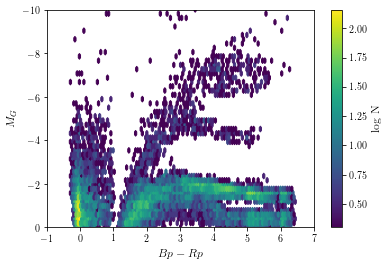

In [19]:
plt.hexbin(brightest_in_bins['phot_bp_mean_mag']-brightest_in_bins['phot_rp_mean_mag'],brightest_in_bins['M_G'],mincnt=1,bins='log')

plt.xlim(-1,7)
plt.ylim(0,-10)
plt.xlabel('$Bp-Rp$')
plt.ylabel('$M_G$')
plt.colorbar(label='log N')
plt.savefig('brightest_in_bins.png')

In [21]:
#Let's write out to CSV, and also write the source_ids so we can xmatch on ARI
brightest_in_bins.to_csv('brightest_2000_per_bin.csv.gz',index=False,compression='gzip')

from astropy.table import Table
good_ids = Table.from_pandas(pd.DataFrame(brightest_in_bins['source_id']))
good_ids.write('brightest_2000_sourceids.csv')

8/21/18 note: these are the ~14000 stars bluer than Bp-Rp=1 with SNR in W1-W2>=3. 
#Let's write out to CSV, and also write the source_ids so we can xmatch on ARI
good_color.to_csv('bright_clean_w1w2_gt3.csv.gz',index=False,compression='gzip')

from astropy.table import Table
good_ids = Table.from_pandas(pd.DataFrame(good['source_id']))
good_ids.write('cleaned_sourceids.csv')

# Now let's play with the sample a bit

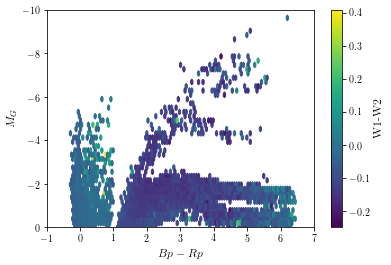

In [22]:
plt.hexbin(brightest_in_bins['phot_bp_mean_mag']-brightest_in_bins['phot_rp_mean_mag'],brightest_in_bins['M_G'],
           C = brightest_in_bins['w1mpro']-brightest_in_bins['w2mpro'],mincnt=1)

plt.xlim(-1,7)
plt.ylim(0,-10)
plt.xlabel('$Bp-Rp$')
plt.ylabel('$M_G$')
plt.colorbar(label='W1-W2')
plt.savefig('brightest2000_W1W2.png')

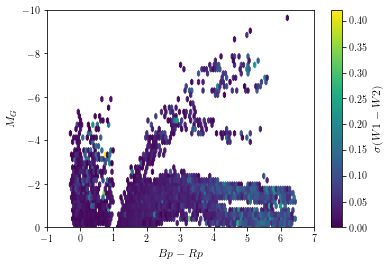

In [25]:
plt.hexbin(brightest_in_bins['phot_bp_mean_mag']-brightest_in_bins['phot_rp_mean_mag'],brightest_in_bins['M_G'],
           C = brightest_in_bins['w1mpro']-brightest_in_bins['w2mpro'],
           reduce_C_function=np.std, mincnt=1)

plt.xlim(-1,7)
plt.ylim(0,-10)
plt.xlabel('$Bp-Rp$')
plt.ylabel('$M_G$')
plt.colorbar(label='$\sigma(W1-W2)$')
plt.savefig('brightest2000_W1W2STD.png')

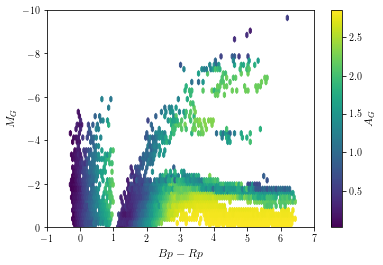

In [26]:
plt.hexbin(brightest_in_bins['phot_bp_mean_mag']-brightest_in_bins['phot_rp_mean_mag'],brightest_in_bins['M_G'],
           C = brightest_in_bins['a_g_val'],mincnt=1)

plt.xlim(-1,7)
plt.ylim(0,-10)
plt.xlabel('$Bp-Rp$')
plt.ylabel('$M_G$')
plt.colorbar(label='$A_G$')
plt.savefig('brightest2000_AG.png')

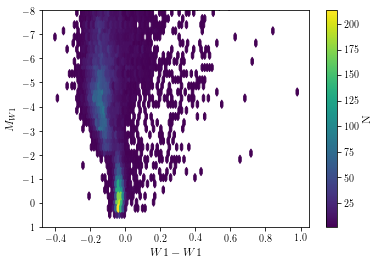

In [33]:
plt.hexbin(brightest_in_bins['w1mpro']-brightest_in_bins['w2mpro'],
           brightest_in_bins['w1mpro']+ 5 * np.log10(brightest_in_bins['parallax']) - 10,
           mincnt=1)

#plt.xlim(-1,7)
plt.ylim(1,-8)
plt.xlabel('$W1-W1$')
plt.ylabel('$M_{W1}$')
plt.colorbar(label='N')
plt.savefig('brightest2000_WiseCMD.png')